## Exercise 0 :

In [161]:
import pandas as pd
import numpy as np

cols = ("top-left-square","top-middle-square","top-right-square","middle-left-square","middle-middle-square",
           "middle-right-square","bottom-left-square","bottom-middle-square","bottom-right-square", "Class")

ttt_df = pd.read_csv("tic-tac-toe.data")

#1.
ttt_df.positive = ttt_df.positive.map({'positive': 1, 'negative': 0})

ttt_df.columns = cols
df_updated = pd.get_dummies(ttt_df)


ttt_df.Class.value_counts()

1    625
0    332
Name: Class, dtype: int64

In [97]:
#2.
n = min(332, df_updated.Class.value_counts().min())
df_stratified = df_updated.groupby('Class').apply(lambda x: x.sample(n))
df_stratified.index = df_stratified.index.droplevel(0)

df_stratified.Class.value_counts()
# df_updated.Class.value_counts()

0    332
1    332
Name: Class, dtype: int64

In [93]:
#3.
df_train = df_stratified.sample(random_state = 3116, frac = 0.8)
df_test = df_stratified.drop(df_train.index)


## Exercise 1:

In [162]:
def learn_logreg_GA(train, test, mu, mup, mum, n, e):
    x_test = test[:, 1:np.shape(test)[1]]
    y_test = test[:, 0].reshape(np.shape(test)[0], 1)
    log_ls = []
    log_lh = []
    fx = []
    betas = np.zeros((np.shape(train)[1] - 1, 1))
    for i in range(0, n):
        np.random.shuffle(train)
        x_train = train[:, 1:np.shape(train)[1]]
        y_train = train[:, 0].reshape(np.shape(train)[0], 1)
        temp = betas
        for k in range(0, np.shape(x_train)[0]):
            res = mu * d_loglikelihood(x_train[k,:].reshape(1, -1), y_train[k,:], betas)
            betas = betas + res
        mu = bold_driver(x_train, y_train, betas, temp, mu, mup, mum)
        log_lh.append(loglike_func(x_train, y_train, betas))  
        log_ls.append(log_loss(x_test, y_test, betas))
        if i > 0:
            fx.append(abs(log_lh[i-1] - log_lh[i]))
            if abs(log_lh[i] - log_lh[i-1]) < e:
                break
    return fx, log_ls

def bold_driver(x_train, y_train, betas, temp, mu, mup, mum):
    if log_loss(x_train, y_train, betas) > log_loss(x_train, y_train, temp):
        mu = mu * mup
    else:
        mu = mu * mum
    return mu

def loglike_func(x_train, y_train, betas):
    return np.sum(y_train * (x_train @ betas) - np.log(1 + np.exp(x_train @ betas)))

def d_loglikelihood(x_train, y_train, betas):
    return x_train.T @ (y_train - (1 / (1 + np.exp((-x_train) @ betas))))

def dd_loglikelihood(x_train, betas):
    temp = np.diag(((1 / (1 + np.exp((-x_train) @ betas))) *
                    (1 - (1 / (1 + np.exp((-x_train) @ betas))))).flatten())
    return x_train.T @ temp @ x_train

def log_loss(x_train, y_train, betas):
    return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) + 
                              (1 - y_train).T @ np.log(1 - 1 / (1 + np.exp((-x_train) @ betas))))


<ipython-input-162-10648ac83de9>:44: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) +


Converged in  191  Iterations


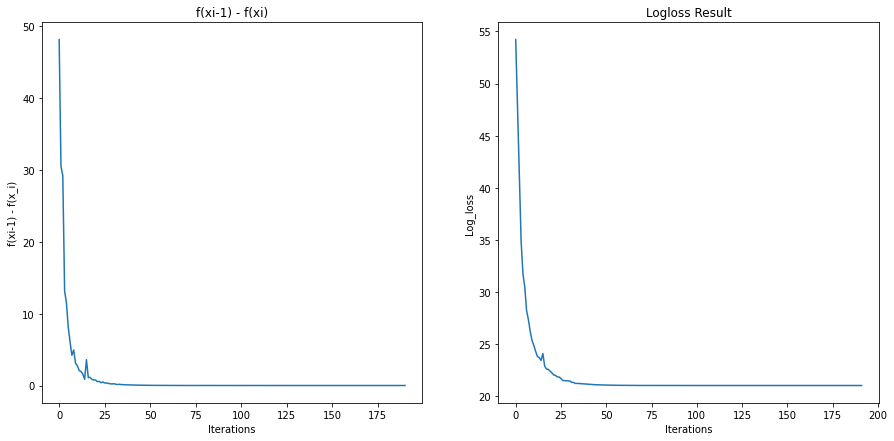

In [163]:
import matplotlib.pyplot as plt

train = df_train.to_numpy()
test = df_test.to_numpy()

mu, mup, mum, imax, e = 0.15, 1.1, 0.9, 300, 1e-8
fx, log_ls = learn_logreg_GA(train, test, mu, mup, mum, imax, e)
if len(fx) < imax:
    print('Converged in ', len(fx), ' Iterations')
    
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(fx)), fx)
plt.xlabel('Iterations')
plt.ylabel('f(xi-1) - f(x_i)')
plt.title('f(xi-1) - f(xi)')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(log_ls)), log_ls)
plt.xlabel('Iterations')
plt.ylabel('Log_loss')
plt.title('Logloss Result')

plt.show()


## Exercise 2:

In [155]:
def minimize_Newton(x_train, y_train, x_test, y_test, betas, mu, n, e):
    loss_lh = []
    loss_ls = []
    fx = []
    for i in range(0, n):
        d1 = d_loglikelihood(x_train, y_train, betas)
        d2 = dd_loglikelihood(x_train, betas)

        betas = betas + (mu * (np.linalg.pinv(d2) @ d1))

        loss_lh.append(loglike_func(x_train, y_train, betas))  
        loss_ls.append(log_loss(x_test, y_test, betas))
        if i > 0:
            fx.append(abs(loss_lh[i - 1] - loss_lh[i]))
            if abs(loss_lh[i] - loss_lh[i - 1]) < e:
                break
    return betas, fx, loss_ls

def learn_logreg_Newton(train, test, mu, n, e):
    x_train = train[:, 1:np.shape(train)[1]]
    betas = np.zeros((np.shape(x_train)[1], 1))
    y_train = train[:, 0].reshape(np.shape(train)[0], 1)
    x_test = test[:, 1:np.shape(test)[1]]
    y_test = test[:, 0].reshape(np.shape(test)[0], 1)
    
    betas, fx, loss_ls = minimize_Newton(x_train, y_train, x_test, y_test, betas, mu, n, e)
    return betas, fx, loss_ls

<ipython-input-140-5805d1d8d9f3>:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) +
<ipython-input-140-5805d1d8d9f3>:47: RuntimeWarning: divide by zero encountered in log
  (1 - y_train).T @ np.log(1 - 1 / (1 + np.exp((-x_train) @ betas))))
<ipython-input-140-5805d1d8d9f3>:47: RuntimeWarning: invalid value encountered in matmul
  (1 - y_train).T @ np.log(1 - 1 / (1 + np.exp((-x_train) @ betas))))


Converged in 149  Iterations


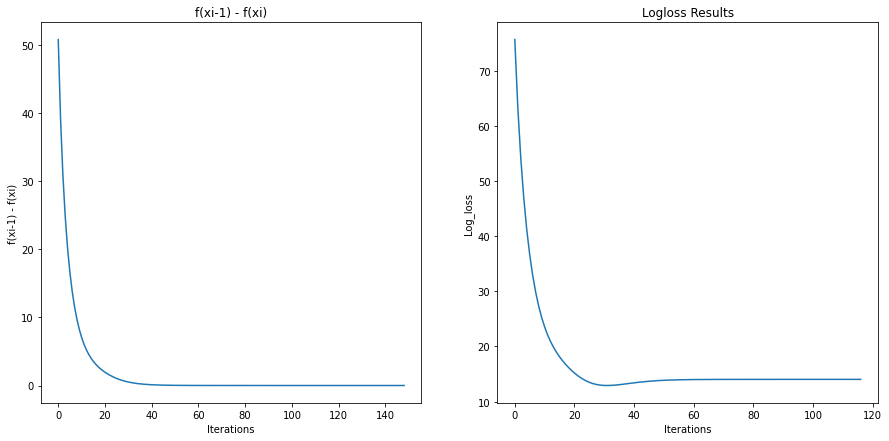

In [157]:
mu, imax, e = 0.15, 160, 1e-8

Betas, fx, loss_ls = learn_logreg_Newton(train, test, mu, imax, e)
if len(fx) < imax - 1:
    print('Converged in', len(fx), ' Iterations')
    
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(fx)), fx)
plt.xlabel('Iterations')
plt.ylabel('f(xi-1) - f(xi)')
plt.title('f(xi-1) - f(xi)')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(loss_ls)), loss_ls)
plt.xlabel('Iterations')
plt.ylabel('Log_loss')
plt.title('Logloss Results')

plt.show()
